In [7]:
import os
import pandas as pd
import nltk
import string
import re
import joblib
import zipfile
import json
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK stopwords if not already available
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

In [1]:
import os
import zipfile

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Path to the ZIP file on your Google Drive
zip_file_path = '/content/drive/MyDrive/ML Task Data One/MachineLearningEngineerTest.zip'
dataset_path = 'data'

# Unzip the file
if not os.path.exists(dataset_path):
    print("Unzipping the dataset...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset unzipped successfully.")
else:
    print("Dataset already unzipped.")

Unzipping the dataset...
Dataset unzipped successfully.


In [8]:
def load_data(ocr_dir):
    """Loads OCR text and labels from the dataset directory."""
    data = []
    # Using 'tqdm' for a progress bar during data loading
    for class_name in tqdm(os.listdir(ocr_dir), desc="Loading OCR Data"):
        class_dir = os.path.join(ocr_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.txt'):
                    file_path = os.path.join(class_dir, file_name)
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        text = f.read()
                        data.append({'text': text, 'label': class_name})
    return pd.DataFrame(data)

# Load the dataset into a DataFrame
df = load_data("/content/ML/data/ocr")
print(f"Loaded {len(df)} documents with {len(df['label'].unique())} classes.")

Loading OCR Data: 100%|██████████| 5/5 [00:00<00:00, 71.69it/s]

Loaded 2500 documents with 5 classes.


In [9]:

def preprocess_text(text):
    """Cleans and preprocesses text data for the model."""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the entire text column
tqdm.pandas(desc="Preprocessing Text")
df['preprocessed_text'] = df['text'].progress_apply(preprocess_text)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['preprocessed_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Transformed text into {X_train_tfidf.shape[1]} features.")

Preprocessing Text: 100%|██████████| 2500/2500 [00:01<00:00, 1689.68it/s]


Transformed text into 5000 features.


In [10]:
# Define the models to be compared
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Support Vector Machine': SVC(random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Store results for comparison
results = []
best_model = None
best_accuracy = 0

for name, model in tqdm(models.items(), desc="Training Models"):
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True),
        'Confusion Matrix': confusion_matrix(y_test, y_pred, labels=model.classes_).tolist()
    })

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Save the best performing model and its vectorizer
if best_model:
    print(f"\nBest model is {type(best_model).__name__} with accuracy: {best_accuracy:.4f}")
    joblib.dump(best_model, 'best_model.joblib')
    joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
    print("Best model and vectorizer saved as joblib files.")


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]


Training Logistic Regression...


Training Models:  25%|██▌       | 1/4 [00:00<00:02,  1.15it/s]

Logistic Regression Accuracy: 0.8600
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       100
           2       0.95      0.88      0.91       100
           4       0.75      0.91      0.82       100
           6       0.93      0.89      0.91       100
           9       0.82      0.77      0.79       100

    accuracy                           0.86       500
   macro avg       0.87      0.86      0.86       500
weighted avg       0.87      0.86      0.86       500


Training Random Forest...


Training Models:  50%|█████     | 2/4 [00:03<00:03,  1.62s/it]

Random Forest Accuracy: 0.8320
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       100
           2       0.87      0.91      0.89       100
           4       0.72      0.94      0.81       100
           6       0.90      0.88      0.89       100
           9       0.84      0.61      0.71       100

    accuracy                           0.83       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.84      0.83      0.83       500


Training Support Vector Machine...


Training Models: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]

Support Vector Machine Accuracy: 0.8560
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       100
           2       0.95      0.87      0.91       100
           4       0.83      0.85      0.84       100
           6       0.93      0.88      0.90       100
           9       0.74      0.84      0.79       100

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500


Training Naive Bayes...
Naive Bayes Accuracy: 0.7960
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       100
           2       0.93      0.87      0.90       100
           4       0.92      0.54      0.68       100
           6       0.89      0.86      0.87       100
           9       0.69      0.87      0.77       100

  


Generating visualizations...
Model accuracy comparison chart saved as 'model_accuracy_comparison.png'.
Detailed metrics comparison chart saved as 'model_metrics_comparison.png'.


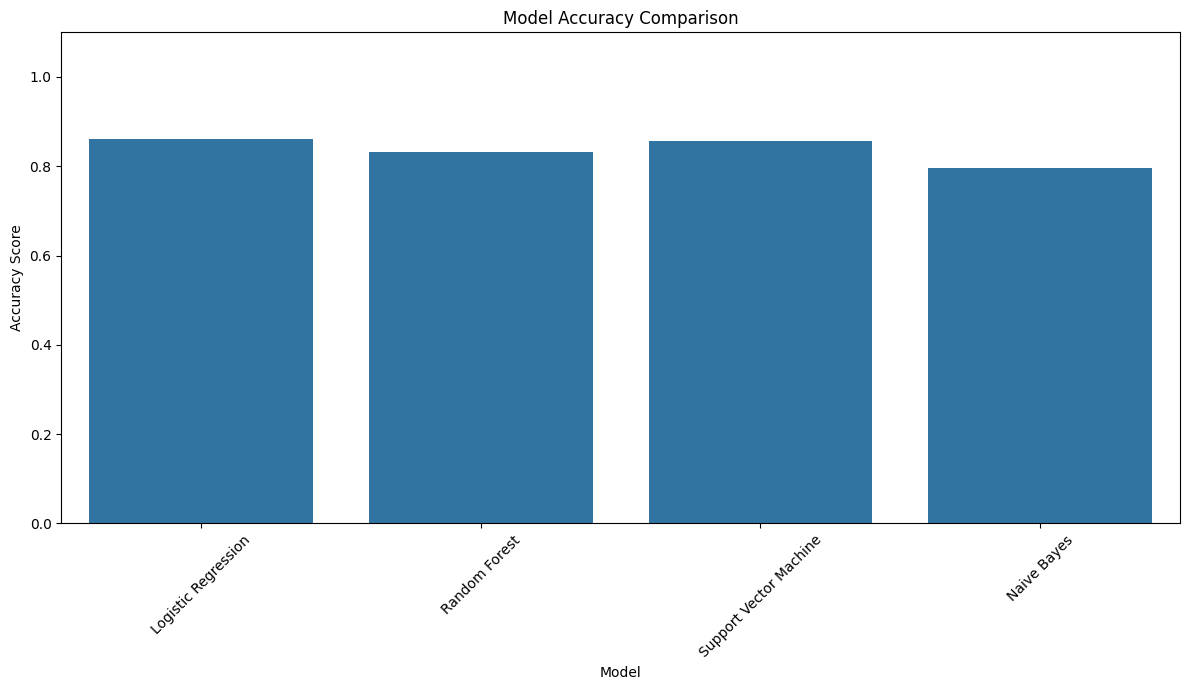

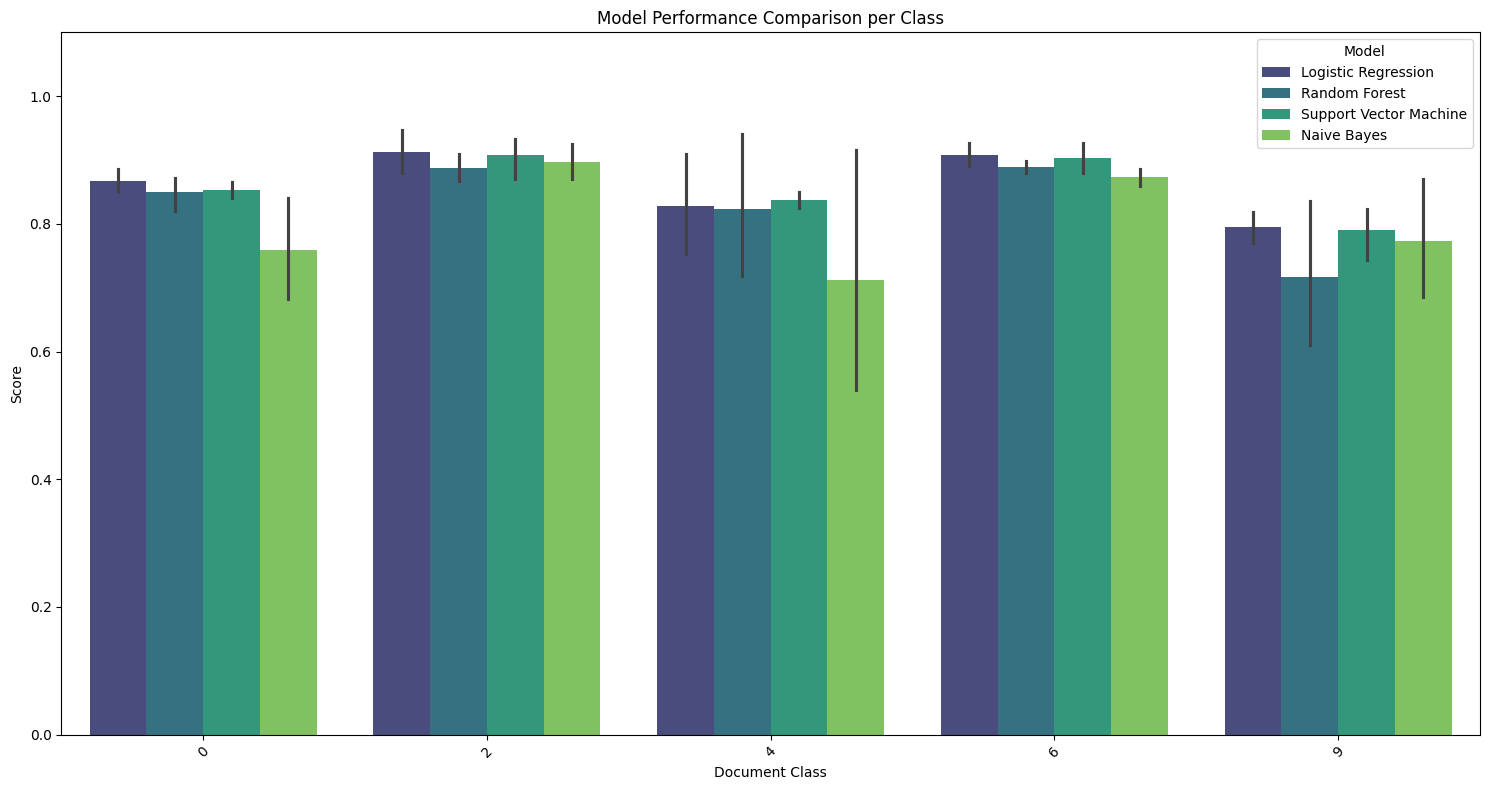

In [11]:
print("\nGenerating visualizations...")

# 1. Model Accuracy Comparison Bar Chart
accuracies = [res['Accuracy'] for res in results]
model_names = [res['Model'] for res in results]

plt.figure(figsize=(12, 7))
sns.barplot(x=model_names, y=accuracies)
plt.ylim(0, 1.1)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_accuracy_comparison.png')
print("Model accuracy comparison chart saved as 'model_accuracy_comparison.png'.")

# 2. Detailed Metrics Comparison Bar Chart (Precision, Recall, F1)
metrics_data = []
for res in results:
    report = res['Classification Report']
    for cls in report.keys():
        if cls not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics_data.append({
                'Model': res['Model'],
                'Class': cls,
                'Metric': 'Precision',
                'Score': report[cls]['precision']
            })
            metrics_data.append({
                'Model': res['Model'],
                'Class': cls,
                'Metric': 'Recall',
                'Score': report[cls]['recall']
            })
            metrics_data.append({
                'Model': res['Model'],
                'Class': cls,
                'Metric': 'F1-Score',
                'Score': report[cls]['f1-score']
            })
df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(15, 8))
sns.barplot(x='Class', y='Score', hue='Model', data=df_metrics, palette='viridis')
plt.ylim(0, 1.1)
plt.title('Model Performance Comparison per Class')
plt.xlabel('Document Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('model_metrics_comparison.png')
print("Detailed metrics comparison chart saved as 'model_metrics_comparison.png'.")

In [12]:
import joblib
import string
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already present
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Define global variables for the model, vectorizer, and stopwords
MODEL_PATH = "best_model.joblib"
VECTORIZER_PATH = "tfidf_vectorizer.joblib"
STOP_WORDS = set(stopwords.words('english'))

# Load the trained model and vectorizer
try:
    model = joblib.load(MODEL_PATH)
    tfidf_vectorizer = joblib.load(VECTORIZER_PATH)
    print("Model and vectorizer loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model or vectorizer files not found. "
          f"Please ensure '{MODEL_PATH}' and '{VECTORIZER_PATH}' "
          f"are in the same directory.")
    exit()

def preprocess_text(text):
    """
    Cleans and preprocesses text data for the model.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

def predict_class(input_text):
    """
    Takes raw text input, preprocesses it, and returns the predicted class.
    """
    # Preprocess the input text
    preprocessed_text = preprocess_text(input_text)

    # Use the TF-IDF vectorizer to transform the text
    text_vector = tfidf_vectorizer.transform([preprocessed_text])

    # Get the model's prediction
    prediction = model.predict(text_vector)

    # Return the predicted class name
    return prediction[0]

# Sample inputs to test
sample_inputs = [
    ("Invoice No: INV-2024-001\nDate: 04/11/2024\nCustomer: John Smith\nItem 1: Laptop, QTY: 1, Price: $1200.00\nTotal Amount Due: $1275.00", "Invoice/Financial"),
    ("Patient: Jane Doe, DOB: 12/05/1990\nSymptoms: Severe headache, fever, and persistent cough. Diagnosis: Influenza. Treatment: Prescribed Ibuprofen and advised rest.", "Medical/Clinical"),
    ("This agreement, made this 15th day of November 2024, between Company A and Company B, hereby outlines the terms of service. The contract is binding for a period of 12 months.", "Legal/Contract"),
    ("Step 1: Unpack the device from the box. Step 2: Connect the power cable to the back of the unit. Step 3: Press and hold the power button for three seconds to turn on the system.", "Technical Manual"),
    ("Resume\nName: Alex Chen\nExperience: Senior Software Engineer at Tech Corp (2020-Present)\nSkills: Python, Java, Machine Learning, AWS, TensorFlow.", "Resume/CV")
]

# Run predictions for each sample input
for text, description in sample_inputs:
    predicted_class = predict_class(text)
    print(f"--- Testing: {description} ---")
    print(f"Predicted Class: {predicted_class}\n")

Model and vectorizer loaded successfully.
--- Testing: Invoice/Financial ---
Predicted Class: 2

--- Testing: Medical/Clinical ---
Predicted Class: 4

--- Testing: Legal/Contract ---
Predicted Class: 0

--- Testing: Technical Manual ---
Predicted Class: 4

--- Testing: Resume/CV ---
Predicted Class: 4

